# Basic LSTM
This is a basic LSTM following the guide at [link text](https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091)


## Forget gate
### Decides what to delete from the past
The forget gate controls how much of the past memory we consider by passing the current input through a sigmoid function together with the hidden layer and bias, and then multiplying it by the previous cell state C_t-1. A smaller value means less relevance of the memory, while a bigger value means more relevance.

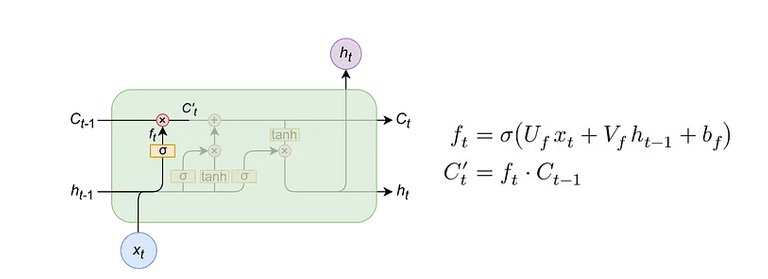

## Input gate
### Decides what to add to the memory from the present
The input gate is where the information contained on the input and hidden state is combined and then operated along with the candidate and partial candidate c'_t, to calculate how much the current information will be relevant to put inside the cell state \
The candidate is a value that represents how much information will be added into the cell state \
On those operations, it is decided how much of the new information will be introduced on the memory and how it will change — that’s why we use a tanh function (“scale” from -1 to 1). We combine the partial candidate from the short-term and long-term memories and set it as the candidate, so that the candidate is influenced by the input gate i_t.


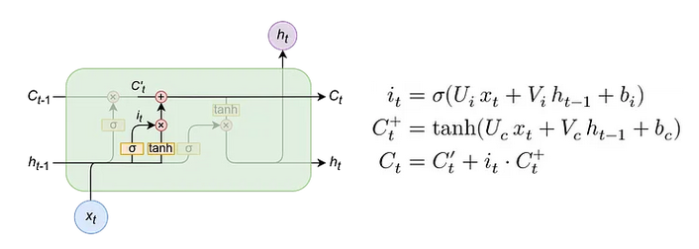

## Output gate
### Decides how much of the current memory should be shared as hidden state
The output gate takes the updated cell state (C_t​), applies a tanh⁡tanh function to scale its values between −1 and 1, and then multiplies this by o_t​ (the output gate's activation vector). This produces the hidden state. The hidden state (h_t​) represents the short-term memory that is immediately relevant for making predictions or decisions at the current time step.
Remember: cell state is private while hidden state is shared


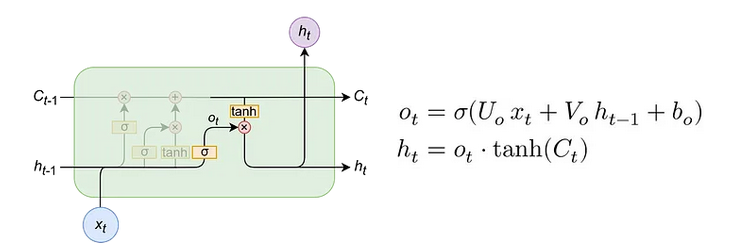

## Recap of the equations

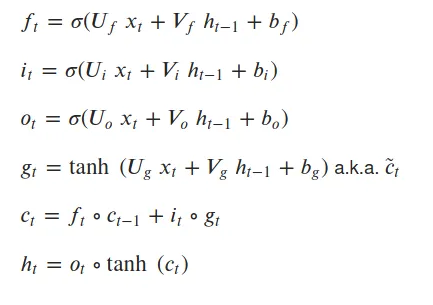

In [1]:
import math
import torch
import torch.nn as nn

## Initialize the LSTM model

In [2]:
class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        #Weights declaration for every gate
        #i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        #f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        #c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        #o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()


In [4]:
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

## Feedforward operation

The feedforward operation receives the init_states parameter, which is a tuple with the (h_t, c_t) parameters of the equations above, which is set to zero if not introduced. We then perform the feedforward of the LSTM equations for each of the sequence elements preserving the (h_t, c_t), and introducing it as the states for the next element of the sequence. \
At the end, we return the predictions and the last states tuple.

In [7]:
    def forward(self,
                    x,
                    init_states=None):

            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            -Batch size: number of examples / data points
            -Sequence size: how many time steps per data point there are
            -Input size: number of features for each data point
            """

            bs, seq_sz, _ = x.size()
            hidden_seq = []

            if init_states is None:
                h_t, c_t = (
                    torch.zeros(bs, self.hidden_size).to(x.device),
                    torch.zeros(bs, self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            for t in range(seq_sz): #for each time stamp
                x_t = x[:, t, :] #at each timestamp we extract the corresponding slice x[batch_size, input_size]

                i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
                f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
                g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
                o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)

                hidden_seq.append(h_t.unsqueeze(0)) #hidden_seq will contain all the hidden states at all
                #time stamps for each sequence

            #reshape hidden_seq p/ retornar
            hidden_seq = torch.cat(hidden_seq, dim=0) #concatenate hidden states in one large tensor
            hidden_seq = hidden_seq.transpose(0, 1).contiguous()
            return hidden_seq, (h_t, c_t) #return hidden sequence and last time stamp (h_t, c_t)

This LSTM is correct in terms of operations but not very optimized in terms of computational time: we perform 8 matrix multiplications separately, which is much slower than doing it in a vectorized way. We will now show how it could be done by reducing it to 2 matrix multiplications, which would make it much faster.

To do this operations, we set two matrixes, U and V, which have the weight contained on the 4 matrix multiplications each of they do. We then perform the gated operations on the matrixes that already passed per the linear combinations + bias operation.

With the vectorized operations, the equations of the LSTM cell would be:

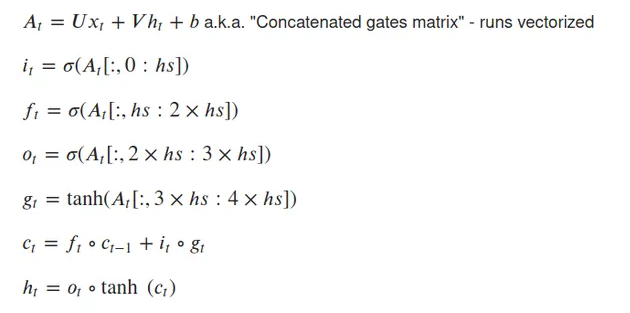

# Optimized LSTM

In [2]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x,
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication, rather than using separate
            #matrices for each parameter. This way weights and biases are shared
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = ( #each slice of gates corresponds to one of the gate
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

# Test the LSTM for predicting sine waves

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Epoch 0, Loss: 0.3504
Epoch 10, Loss: 0.0080
Epoch 20, Loss: 0.0042
Epoch 30, Loss: 0.0027
Epoch 40, Loss: 0.0035


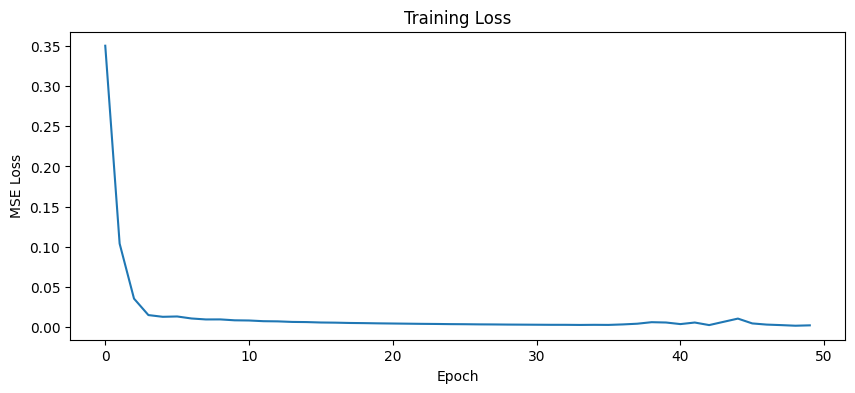

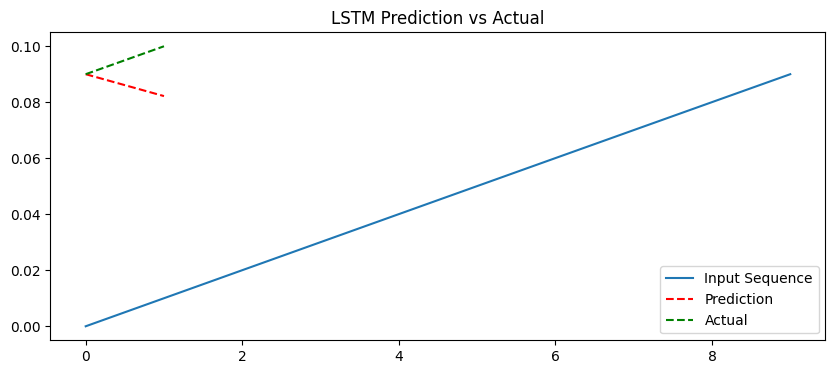

In [14]:
# Generate a simple sine wave dataset
def generate_data(samples=1000):
    x = np.linspace(0, 100, samples)
    y = np.sin(0.1 * x)
    return y

# Create sequences from the sine wave
def create_sequences(data, seq_length=10):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Test the LSTM
def test_lstm():
    # Generate data
    data = generate_data()
    X, y = create_sequences(data)

    # Convert to tensors and reshape
    X = torch.FloatTensor(X).unsqueeze(-1)  # Shape: [batch, sequence, feature]
    y = torch.FloatTensor(y)

    # Create model
    input_size = 1  # Single feature (sine wave value)
    hidden_size = 32
    model = CustomLSTM(input_size, hidden_size)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    n_epochs = 50
    batch_size = 32
    n_batches = len(X) // batch_size

    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            batch_X = X[start_idx:end_idx]
            batch_y = y[start_idx:end_idx]

            # Forward pass
            hidden_seq, _ = model(batch_X)
            predictions = hidden_seq[:, -1, 0]  # Take last hidden state

            # Compute loss
            loss = criterion(predictions, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.show()

    # Test prediction
    model.eval()
    test_seq = X[:1]  # Take first sequence as test
    with torch.no_grad():
        hidden_seq, _ = model(test_seq)
        prediction = hidden_seq[:, -1, 0]

    # Plot prediction vs actual
    plt.figure(figsize=(10, 4))
    plt.plot(test_seq[0, :, 0].numpy(), label='Input Sequence')
    plt.plot([test_seq[0, -1, 0].item(), prediction.item()], 'r--', label='Prediction')
    plt.plot([test_seq[0, -1, 0].item(), y[0].item()], 'g--', label='Actual')
    plt.legend()
    plt.title('LSTM Prediction vs Actual')
    plt.show()

    return model

if __name__ == "__main__":
    model = test_lstm()